In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [86]:
df = pd.read_csv('Hotel_Reservations_clean.csv')
df.head(3)

,index,Booking_ID,num_adults,num_children,weekend_nights,week_nights,total_nights,meal_plan,car_parking,room_type,...,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status,meal_plan_cod,room_type_cod,mkt_segment_cod,arrival_season_cod,booking_status_cod,is_outlier
0,0,INN00001,2,0,1,2,3,Meal Plan 1,0,Room_Type 1,...,0,65.00,0,No cancelada,1,1,3,3,0,1
1,1,INN00002,2,0,2,3,5,Not Selected,0,Room_Type 1,...,0,106.68,1,No cancelada,0,1,4,1,0,1
2,2,INN00003,1,0,2,1,3,Meal Plan 1,0,Room_Type 1,...,0,60.00,0,Cancelada,1,1,4,1,1,1


### Pre-Procesamiento

#### Codificacion de variables cualitativas

In [87]:
var_dummy = pd.get_dummies(df.mkt_segment, dtype=int)
var_dummy.head(3)

,Aviation,Complementary,Corporate,Offline,Online
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1


#### Feature engineering

In [88]:
x = pd.concat([df[['lead_time','num_sp_requests','avg_price_room','car_parking',
                   'meal_plan_cod', 'num_adults','num_children','weekend_nights',
                   'week_nights','room_type_cod']], var_dummy], axis=1)

y = df.booking_status

### Model Train

#### Entrenamiento

In [89]:
#SPLIT DE LOS DATOS PARA ENTRENAR Y VALIDAR
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(max_depth=18, max_features=0.5, n_estimators=300, random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

#### Metricas

In [90]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

   Cancelada       0.87      0.78      0.82      3907
No cancelada       0.90      0.94      0.92      8017

    accuracy                           0.89     11924
   macro avg       0.89      0.86      0.87     11924
weighted avg       0.89      0.89      0.89     11924



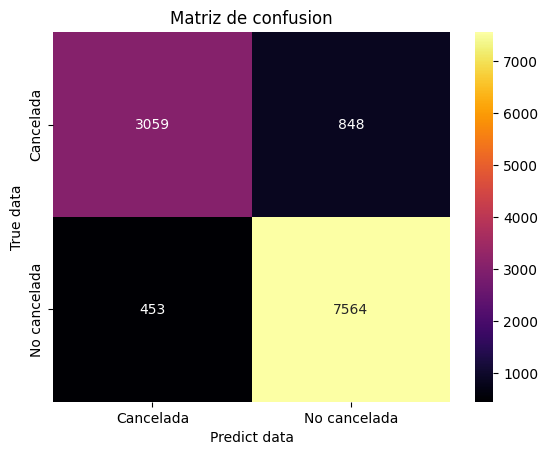

In [91]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, fmt='.0f', annot=True, cmap='inferno')
plt.title('Matriz de confusion')
plt.xlabel('Predict data')
plt.xticks(ticks=[0.5,1.5], labels=['Cancelada','No cancelada'])
plt.ylabel('True data')
plt.yticks(ticks=[0.5,1.5], labels=['Cancelada','No cancelada'])
plt.show()